# Analysis of Datetime Bugs

In [226]:
# Install dependencies if missing
%pip install matplotlib
%pip install seaborn
%pip install pandas
%pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 25.0
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 25.0
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 25.0
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal si

In [227]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors

SAVE_PATH = "./visualizations/"

# Read the data from the TSV file
df = pd.read_csv('./data/bugs_analysis_base.tsv', sep='\t')
print("Total number of datapoints: ", len(df))
df.head()

Total number of datapoints:  151


,Owner,Project,Title,Link,Fix Link,Stars,TF-IDFs,Size,Datetime,Arrow,...,Erroneous Computation 1,Erroneous Computation 2,Erroneous Computation 3,Obscurity,Impact,# LOC,Logic Needed,Bug Pattern 1,Bug Pattern 2,Bug Pattern 3
0,python-poetry,tomlkit,datetime.utcnow and datetime.utcfromtimestamp ...,https://github.com/python-poetry/tomlkit/issue...,https://github.com/python-poetry/tomlkit/commi...,643.0,1.312623,1001.0,1.0,0.0,...,Datetime (Construction),NaN,NaN,Low,Low,Low,Low,Outdated/Deprecated APIs,NaN,NaN
1,frictionlessdata,frictionless-py,SpssParser ignores timezones,https://github.com/frictionlessdata/frictionle...,https://github.com/frictionlessdata/frictionle...,683.0,1.270077,1279.0,1.0,0.0,...,Datetime (Construction),Parsing/Formatting,NaN,Low,Medium,Medium,High,Dropping Time Zone Information,NaN,NaN
2,sdispater,pendulum,Deepcopy of Month-based Duration produces a di...,https://github.com/sdispater/pendulum/issues/714,https://github.com/sdispater/pendulum/commit/9...,6109.0,1.191295,1014.0,1.0,0.0,...,Delta API,NaN,NaN,Medium,Medium,Medium,Low,Unintuitive Arithmetic,NaN,NaN
3,googleapis,python-storage,`DeprecationWarning` warning in build log for ...,https://github.com/googleapis/python-storage/i...,https://github.com/googleapis/python-storage/c...,420.0,1.176351,10349.0,1.0,0.0,...,Datetime (Arithmetic),NaN,NaN,Low,Low,Low,Low,Outdated/Deprecated APIs,NaN,NaN
4,googleapis,python-logging,`DeprecationWarning` warning in build log for ...,https://github.com/googleapis/python-logging/i...,https://github.com/googleapis/python-logging/p...,119.0,1.167279,2673.0,1.0,0.0,...,Datetime (Construction),NaN,NaN,Low,Low,Low,Low,Outdated/Deprecated APIs,NaN,NaN


df.columns
"""
Index(
       ['Owner', 'Project', 'Title', 'Stars', 'TF-IDFs', 'Size', 'Datetime',
       'Arrow', 'Pendulum', 'Description', 'Category 1', 'Category 2',
       'Erroneous Computation 1', 'Erroneous Computation 2',
       'Bug Pattern 3', 'Obscurity', 'Impact/Severity', '# LOC',
       'Logic Needed', 'Comments', 'BPST1', 'BPST2', 'BPST3'],
dtype='object')
"""

## What are the highlevel terms used to describe date and time bugs?

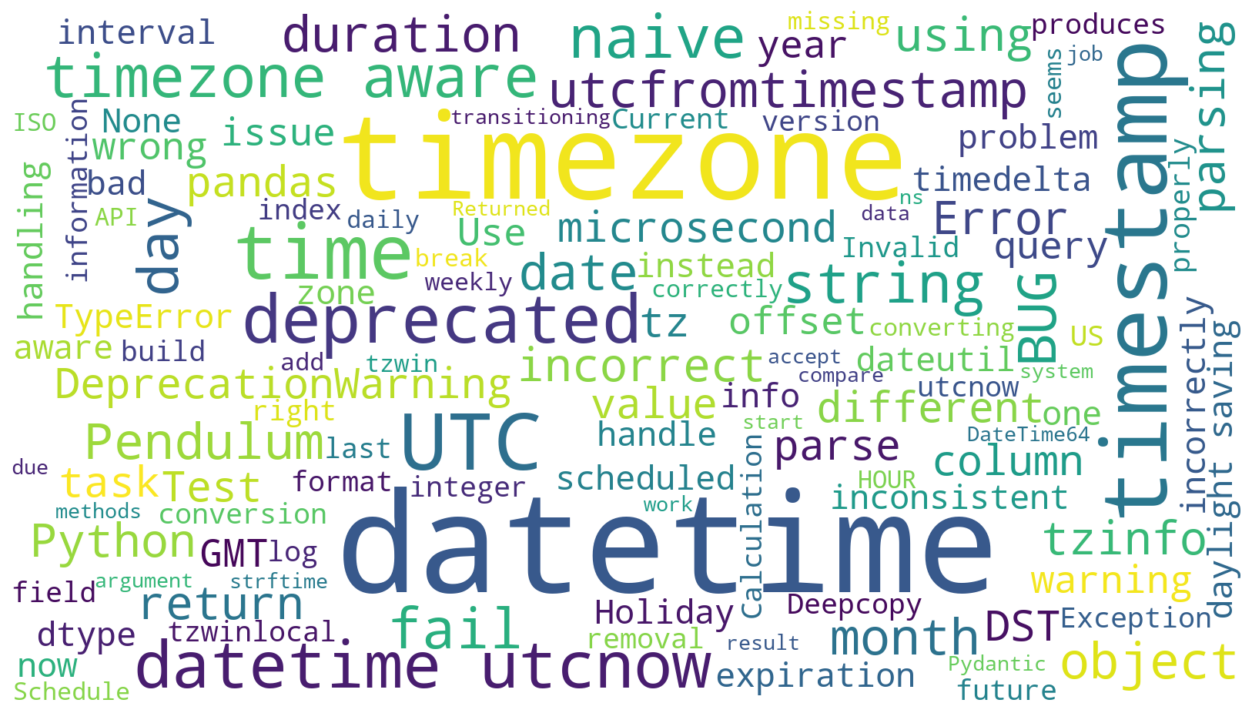

In [228]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image

# 1. Combine all text from the column into a single string
text = ' '.join(df['Title'].astype(str))

# 2. Create a WordCloud object
wordcloud = WordCloud(
    width=1600, 
    height=900, 
    max_font_size=180,
    max_words=120,
    background_color="white",
    colormap='viridis',
    # mask=datetime_mask,
    contour_width=1,
    ).generate(text)

# 3. Display the generated image
plt.figure(figsize=(16, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig(SAVE_PATH+'wordcloud.pdf', format='pdf', bbox_inches='tight')
plt.show()


# Stats about bug obscurity/impact and fix complexity/#loc

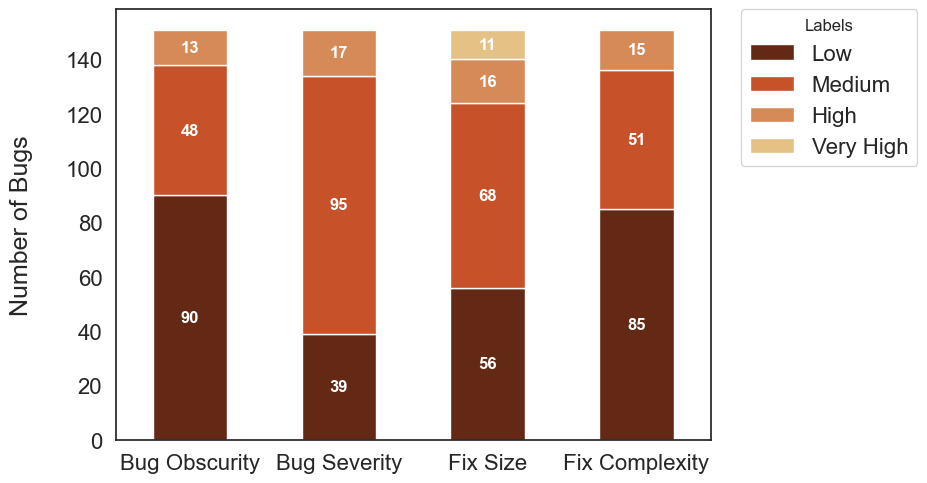

In [229]:
# Define the colors for the bar chart
colors = ["#642915", "#c7522a", "#d68a58", "#e5c185", "#74a892", "#094d4d", "#80c2c2", "#b1e0e0"]
sns.set_theme(style='white')

# select only specific columns
df_new = df[['# LOC', 'Logic Needed', 'Obscurity', 'Impact']]

# Count occurrences for each category in each column
loc_counts = df_new['# LOC'].value_counts()
logic_counts = df_new['Logic Needed'].value_counts()
obscurity_counts = df_new['Obscurity'].value_counts()
impact_counts = df_new['Impact'].value_counts()

# Ensure all categories are in the same order
categories = ['Low', 'Medium', 'High', 'Very High']
loc_counts = loc_counts.reindex(categories, fill_value=0)
logic_counts = logic_counts.reindex(categories, fill_value=0)
obscurity_counts = obscurity_counts.reindex(categories, fill_value=0)
impact_counts = impact_counts.reindex(categories, fill_value=0)

# Compose the data for a stacked bar chart
stacked_data = pd.DataFrame({
    'Bug Obscurity': obscurity_counts,
    'Bug Severity': impact_counts,
    'Fix Size': loc_counts,
    'Fix Complexity': logic_counts,
}, index=categories)

# Transpose the data for plotting
stacked_data = stacked_data.T

# Plotting
ax = stacked_data.plot(kind='bar', stacked=True, color=colors[:4], figsize=(12, 5), width=0.5)

# Iterate over each column in the DataFrame and display the value on the bars
for i, bar in enumerate(ax.containers):
    # Use ax.bar_label() in case of Matplotlib >= 3.4
    ax.bar_label(bar, label_type='center', fontsize=12, color='white', fontweight='bold', labels=['' if v==0 else int(v) for v in bar.datavalues])
    # ax.bar_label(bar, label_type='center', fontsize=12, color='white', labels=['' if v==0 else int(v) for v in bar.datavalues])

# Place legend outside the plot
ax.legend(title='Labels', fontsize=16, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Set labels and layout
ax.set_ylabel('Number of Bugs\n', fontsize=18)
ax.tick_params(axis='y', labelsize=16)  
ax.tick_params(axis='x', labelsize=16, rotation=0) 

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 0.8, 1])

# Save and show the plot
plt.savefig(SAVE_PATH + 'stacked_bar_chart.pdf', transparent=True, bbox_inches='tight')
plt.show()

## What are the most common causes of bugs?
### Plot the Broad Categories.

/var/folders/gg/nddyhpc10f5f1y17l64pb9_r0000gq/T/ipykernel_99932/615196150.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Count', y='Category', data=category_counts, palette=colors)
/var/folders/gg/nddyhpc10f5f1y17l64pb9_r0000gq/T/ipykernel_99932/615196150.py:20: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  ax = sns.barplot(x='Count', y='Category', data=category_counts, palette=colors)


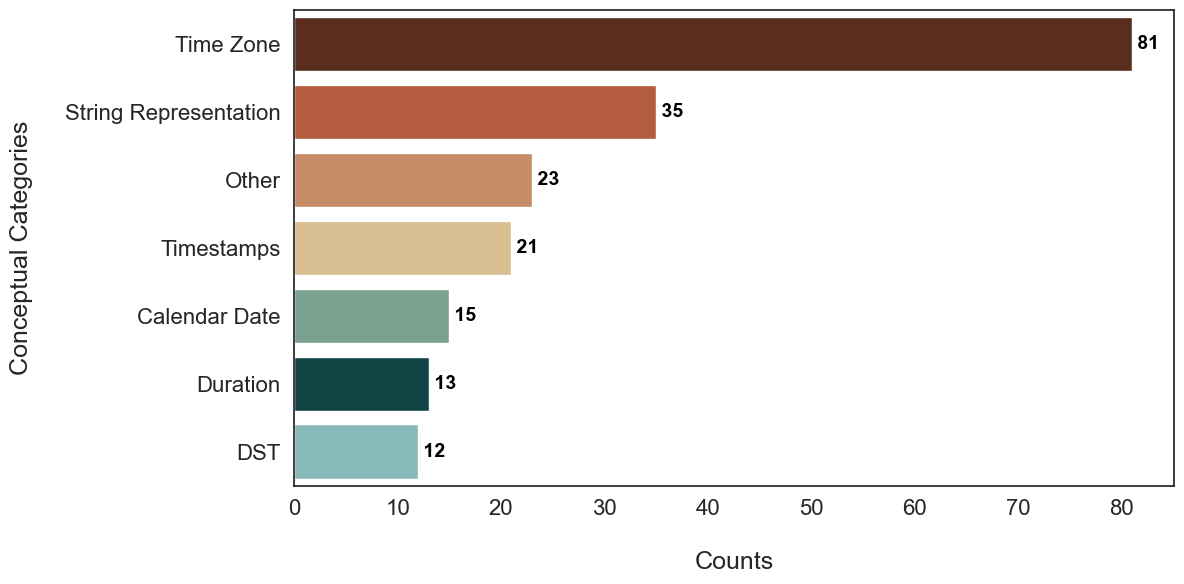

/var/folders/gg/nddyhpc10f5f1y17l64pb9_r0000gq/T/ipykernel_99932/615196150.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Count', y='Category', data=category_counts, palette=colors)
/var/folders/gg/nddyhpc10f5f1y17l64pb9_r0000gq/T/ipykernel_99932/615196150.py:57: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  ax = sns.barplot(x='Count', y='Category', data=category_counts, palette=colors)


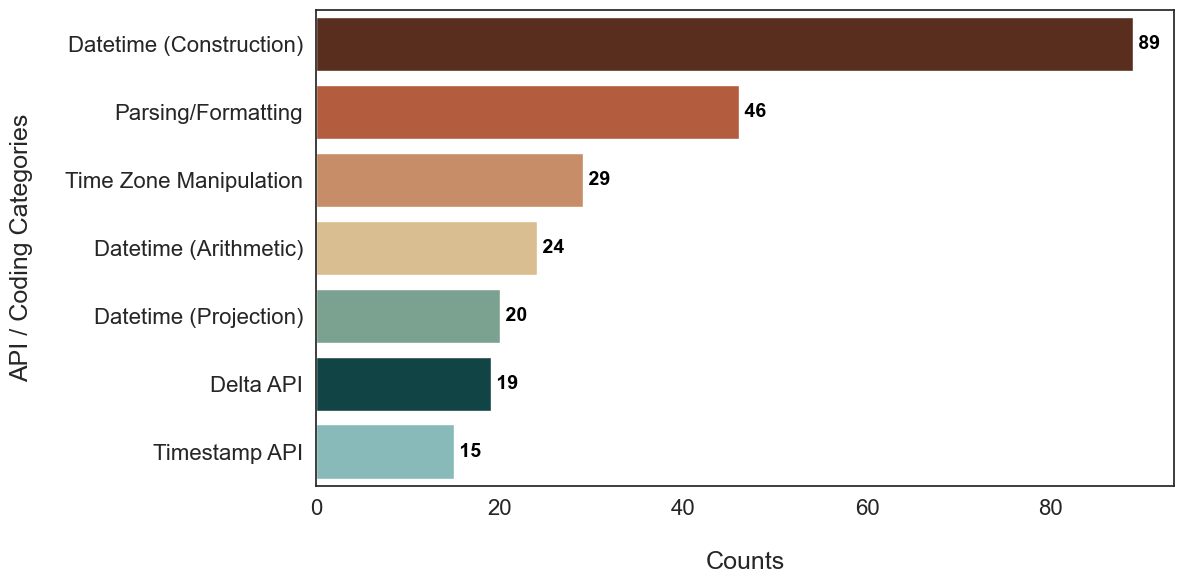

/var/folders/gg/nddyhpc10f5f1y17l64pb9_r0000gq/T/ipykernel_99932/615196150.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Count', y='Category', data=category_counts, palette=colors)
/var/folders/gg/nddyhpc10f5f1y17l64pb9_r0000gq/T/ipykernel_99932/615196150.py:95: UserWarning: 
The palette list has fewer values (8) than needed (11) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x='Count', y='Category', data=category_counts, palette=colors)


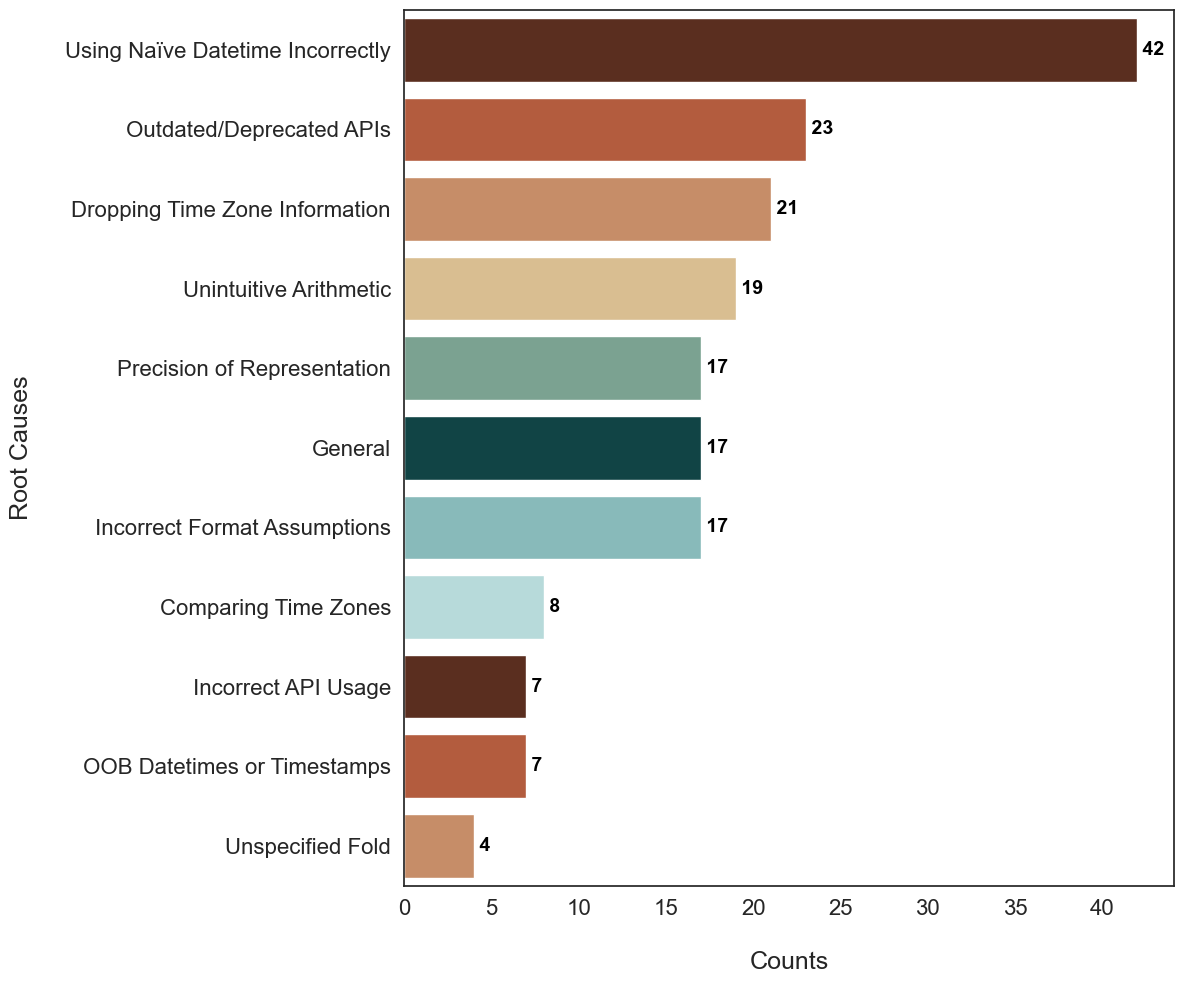

In [230]:
# Define the colors for the bar chart
colors = ["#642915", "#c7522a", "#d68a58", "#e5c185", "#74a892", "#094d4d", "#80c2c2", "#b1e0e0"]
sns.set_theme(style='white')

#######################################################################################

# Conceptual Categories
# Merge both categories into one Series
combined_categories = pd.concat([df['Category 1'], df['Category 2']])

# Count occurrences of each category
category_counts = combined_categories.value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

# Sort DataFrame by Count
category_counts = category_counts.sort_values("Count", ascending=False)

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Count', y='Category', data=category_counts, palette=colors)

# Add annotations
for index, row in category_counts.iterrows():
    ax.text(row.Count, index, f' {row.Count} ', color='black', ha="left", va="center", fontsize=14, fontweight='bold')

# Set labels and titles
ax.set_xlabel('\nCounts', fontsize=18)
ax.set_ylabel('Conceptual Categories\n', fontsize=18)
ax.tick_params(axis='y', labelsize=16)  # Use this to control y-tick label sizes
ax.tick_params(axis='x', labelsize=16)  # Use this to control x-tick label sizes

plt.tight_layout()
plt.savefig(SAVE_PATH + 'conceptual_categories.pdf', bbox_inches='tight')
plt.show()

#######################################################################################


# What are the most common Erroneous Computations?
timezone_df = df.copy()

# Merge all Erroneous Computation columns into one Series
combined_categories = pd.concat([timezone_df['Erroneous Computation 1'], 
                                 timezone_df['Erroneous Computation 2'], 
                                 timezone_df['Erroneous Computation 3']])
combined_categories = combined_categories.dropna()

# Count occurrences of each category
category_counts = combined_categories.value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

# Sort DataFrame by Count
category_counts = category_counts.sort_values("Count", ascending=False)

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Count', y='Category', data=category_counts, palette=colors)

# Add annotations
for index, row in category_counts.iterrows():
    ax.text(row.Count, index, f' {row.Count} ', color='black', ha="left", va="center", fontsize=14, fontweight='bold')

# Set labels and titles
ax.set_xlabel('\nCounts', fontsize=18)
ax.set_ylabel('API / Coding Categories\n', fontsize=18)
ax.tick_params(axis='y', labelsize=16)  # Use this to control y-tick label sizes
ax.tick_params(axis='x', labelsize=16)  # Use this to control x-tick label sizes

plt.tight_layout()
plt.savefig(SAVE_PATH + 'api_categories.pdf', bbox_inches='tight')
plt.show()


#######################################################################################


# What are the most common Bugs?
timezone_df = df.copy()

# Merge Bug Patterns into one Series
combined_categories = pd.concat([timezone_df['Bug Pattern 1'], 
                                 timezone_df['Bug Pattern 2'], 
                                 timezone_df['Bug Pattern 3']])
combined_categories = combined_categories.dropna()

# Count occurrences of each category
category_counts = combined_categories.value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

# Sort DataFrame by Count
category_counts = category_counts.sort_values("Count", ascending=False)

# Plotting
plt.figure(figsize=(12, 10))
ax = sns.barplot(x='Count', y='Category', data=category_counts, palette=colors)

# Add numerical annotations on each bar
for index, row in category_counts.iterrows():
    ax.text(row.Count, index, f' {row.Count} ', color='black', ha='left', va='center', fontsize=14, fontweight='bold')

# Set labels and titles
ax.set_xlabel('\nCounts', fontsize=18)
ax.set_ylabel('Root Causes\n', fontsize=18)
ax.tick_params(axis='y', labelsize=16)  # Manage y-tick label sizes
ax.tick_params(axis='x', labelsize=16)  # Manage x-tick label sizes

plt.tight_layout()
plt.savefig(SAVE_PATH + 'root_causes.pdf', bbox_inches='tight')
plt.show()

     Bug Obscurity  Bug Severity  Fix Size  Fix Complexity
0                1             1         1               1
1                1             2         2               3
2                2             2         2               1
3                1             1         1               1
4                1             1         1               1
..             ...           ...       ...             ...
146              1             2         1               1
147              2             2         3               2
148              1             1         2               1
149              2             1         2               2
150              3             1         1               1

[151 rows x 4 columns]
                Bug Obscurity  Bug Severity  Fix Size  Fix Complexity
Bug Obscurity        1.000000     -0.107202  0.115292        0.218010
Bug Severity        -0.107202      1.000000  0.082258        0.180872
Fix Size             0.115292      0.082258  1.000000     

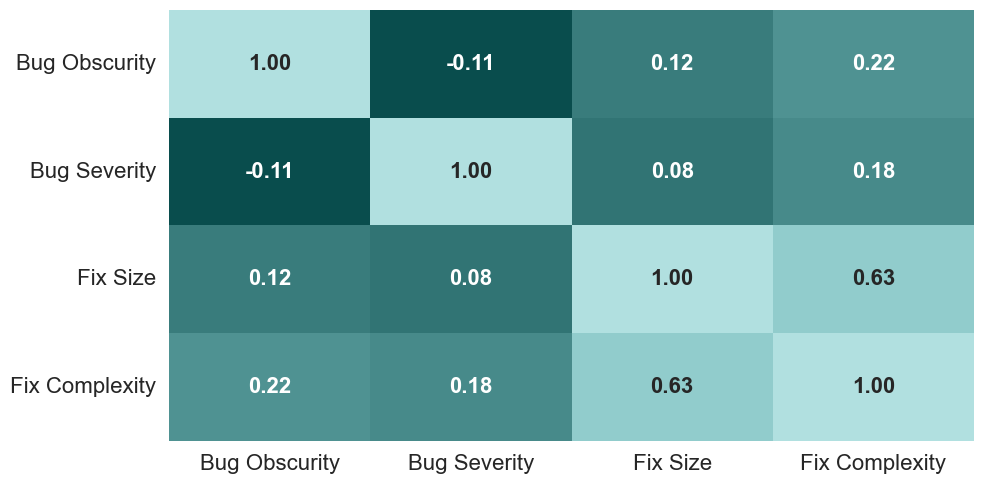

In [231]:
# Convert low, medium, high to 1, 2, 3 for 'Obscurity', 'Impact', '# LOC', and 'Logic Needed'
df_temp = df.copy()
df_temp['Impact'] = df['Impact'].map({'Low': 1, 'Medium': 2, 'High': 3})
df_temp['Obscurity'] = df['Obscurity'].map({'Low': 1, 'Medium': 2, 'High': 3})
df_temp['# LOC'] = df['# LOC'].map({'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4})
df_temp['Logic Needed'] = df['Logic Needed'].map({'Low': 1, 'Medium': 2, 'High': 3})

df_temp = df_temp[['Obscurity', 'Impact', '# LOC', 'Logic Needed']]
df_temp = df_temp.dropna()

# rename the columns
df_temp.columns = ['Bug Obscurity', 'Bug Severity', 'Fix Size', 'Fix Complexity']

print(df_temp)
print(df_temp.corr())

# Define your color map
colors = ["#642915", "#c7522a", "#d68a58", "#e5c185", "#74a892", "#094d4d", "#80c2c2", "#b1e0e0"]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("", colors[5:])

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 5))  # Adjust width and height as needed

# Create the heatmap using the ax object
sns.heatmap(df_temp.corr(),
            annot=True,
            annot_kws={"size": 16, "weight": "bold"},
            cmap=custom_cmap,
            fmt=".2f",
            cbar=False,
            ax=ax)  # Pass the ax object here

# Set the tick labels size and rotation using ax
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16, rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=16, rotation=0)

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig(SAVE_PATH+'correlation_plot.pdf', transparent=True, bbox_inches='tight')
plt.show()


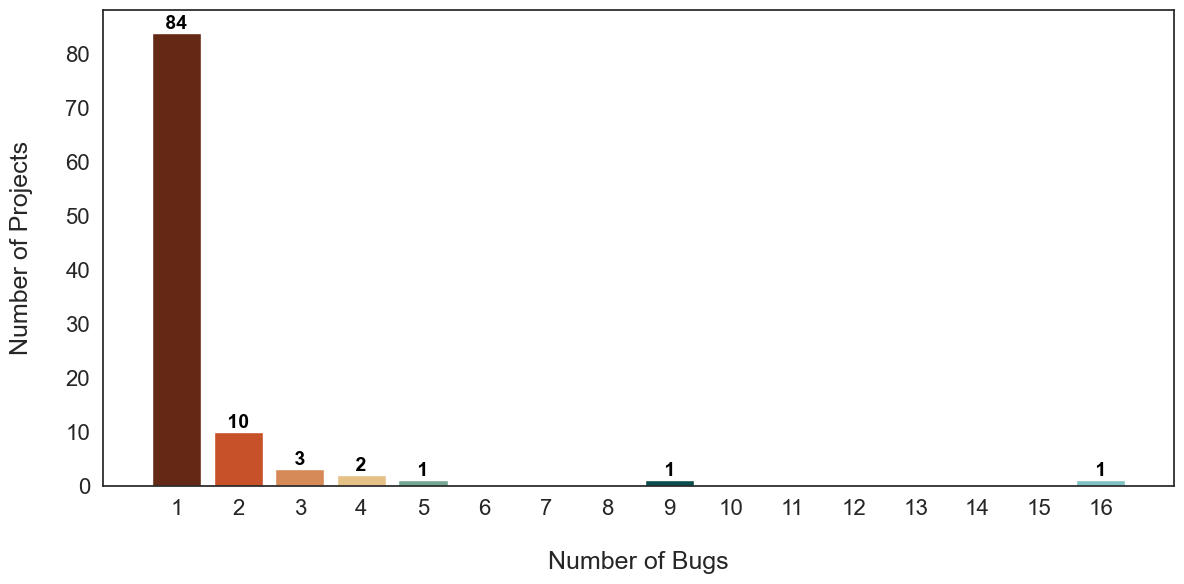

In [232]:
# Distribution of bugs from different contributing projects

# Set the theme using seaborn
sns.set_theme(style='white')

# Count the number of bugs per project
bug_counts = df['Project'].value_counts()

# Define the colors for the bar chart
colors = ["#642915", "#c7522a", "#d68a58", "#e5c185", "#74a892", "#094d4d", "#80c2c2", "#b1e0e0"]

# Create a new figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Calculate the number of projects for each number of bugs
bug_count_values = bug_counts.value_counts().sort_index()

# Plot the histogram using ax.bar for more control over colors
bars = ax.bar(bug_count_values.index, bug_count_values.values, color=colors[:len(bug_count_values)])

# Set labels
ax.set_xlabel('\nNumber of Bugs', size=18)
ax.set_ylabel('Number of Projects\n', size=18)

# Set x-ticks
ax.set_xticks(range(1, bug_counts.max() + 1))
ax.tick_params(axis='x', labelsize=16)  # X-axis tick labels
ax.tick_params(axis='y', labelsize=16)  # Y-axis tick labels

# Add numerical annotations on each bar
for index, value in enumerate(bug_count_values.values):
    ax.text(bug_count_values.index[index], value, f' {value} ', color='black', ha='center', va='bottom', fontsize=14, fontweight='bold')

# Save and show the plot
plt.tight_layout()
plt.savefig(SAVE_PATH + 'bug_distribution.pdf', transparent=True, bbox_inches='tight')
plt.show()

### Plot the broad categories, and also show which bugs are in general projects and which ones are in datetime libraries

In [233]:
# Setup for figures 2-4

# project names for datetime libraries
datetime_libraries = ["dateutil", "pendulum", "maya", "Chronyk", "arrow"]


# define the colors for the bar chart
from matplotlib.colors import to_rgb
colors = ["#642915", "#c7522a", "#d68a58", "#e5c185", "#74a892", "#094d4d", "#80c2c2", "#b1e0e0"]
colors = colors[::-1]
darker_colors = [f"#{''.join(f'{int(c*255 * (1 - 0.3)):02x}' for c in to_rgb(color))}" for color in colors]

sns.set_theme(style='white')

/var/folders/gg/nddyhpc10f5f1y17l64pb9_r0000gq/T/ipykernel_99932/2737350670.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new["In Library"] = df['Project'].apply(lambda x: "Datetime Library" if x in datetime_libraries else "General Project")


           In Library             Categories
0     General Project                  Other
1     General Project              Time Zone
2    Datetime Library               Duration
3     General Project                  Other
4     General Project                  Other
..                ...                    ...
195   General Project             Timestamps
196   General Project             Timestamps
197   General Project  String Representation
198   General Project          Calendar Date
199   General Project             Timestamps

[200 rows x 2 columns]


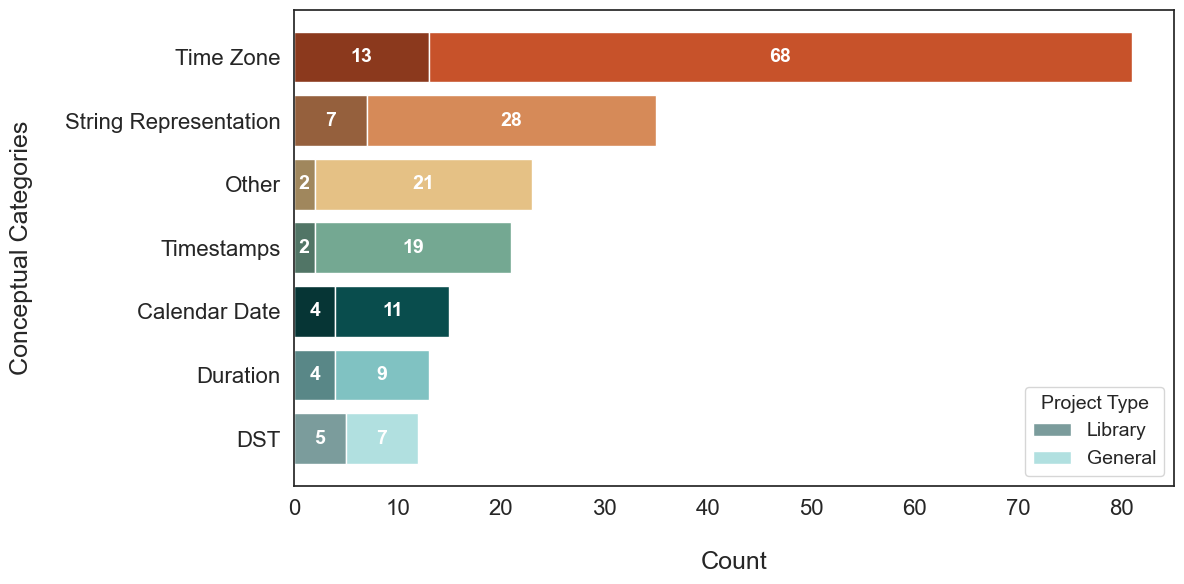

In [234]:
# Figure 2: distribution of bugs across identified conceptual categories

df_new = df[['Project', 'Category 1', 'Category 2']]
df_new["In Library"] = df['Project'].apply(lambda x: "Datetime Library" if x in datetime_libraries else "General Project")

melted_df = df_new.melt(
    id_vars=["In Library"],
    value_vars=['Category 1', 'Category 2'],
    value_name="Categories"
)

# Drop rows with NaN in the "Categories" column and select relevant columns
result_df = melted_df.dropna(subset=["Categories"])[["In Library", "Categories"]]

# Reset the index for the final DataFrame
result_df = result_df.reset_index(drop=True)

# Display the result
print(result_df)

# Group and count occurrences for each combination of "Errors" and "In Library"
grouped_data = result_df.groupby(["Categories", "In Library"]).size().unstack(fill_value=0)

# Sort bars by total counts (sum of both columns) in descending order
grouped_data["Total"] = grouped_data.sum(axis=1)
grouped_data = grouped_data.sort_values("Total", ascending=True).drop(columns=["Total"])

# Assign colors for each bar: original for "In Datetime Library" and lighter for "In General Project"
bar_colors = []
for i in range(len(grouped_data)):
    bar_colors.append((darker_colors[i], colors[i]))

# Plotting the stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))
for i, (library_type, color_pair) in enumerate(zip(grouped_data.columns, zip(*bar_colors))):
    ax.barh(
        grouped_data.index, grouped_data.iloc[:, i],
        label=library_type,
        color=color_pair,
        height=0.8,
        edgecolor="white",
        align="center",
        left=grouped_data.iloc[:, :i].sum(axis=1) if i > 0 else None,
    )

# Adding data labels
for container in ax.containers:
    labels = [f'{int(value)}' if value > 0 else '' for value in container.datavalues]
    ax.bar_label(container, labels=labels, label_type='center', color='white', fontsize=14, fontweight='bold') 

# Customizing the chart
ax.set_xlabel("\nCount", fontsize=18)
ax.set_ylabel("Conceptual Categories\n", fontsize=18)
ax.legend(["Library", "General"], title="Project Type", fontsize=14, title_fontsize=14, loc="lower right")

# Adjusting ticks
ax.tick_params(axis="x", labelsize=16)
ax.tick_params(axis="y", labelsize=16)

# Display and save the chart
plt.tight_layout()
plt.savefig(SAVE_PATH + 'conceptual_categories_stacked.pdf', bbox_inches='tight')
plt.show()

/var/folders/gg/nddyhpc10f5f1y17l64pb9_r0000gq/T/ipykernel_99932/3505185138.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new["In Library"] = df['Project'].apply(lambda x: "In Datetime Library" if x in datetime_libraries else "In General Project")


              In Library                   Errors
0     In General Project  Datetime (Construction)
1     In General Project  Datetime (Construction)
2    In Datetime Library                Delta API
3     In General Project    Datetime (Arithmetic)
4     In General Project  Datetime (Construction)
..                   ...                      ...
237   In General Project  Datetime (Construction)
238   In General Project                Delta API
239   In General Project       Parsing/Formatting
240  In Datetime Library    Datetime (Projection)
241  In Datetime Library                Delta API

[242 rows x 2 columns]


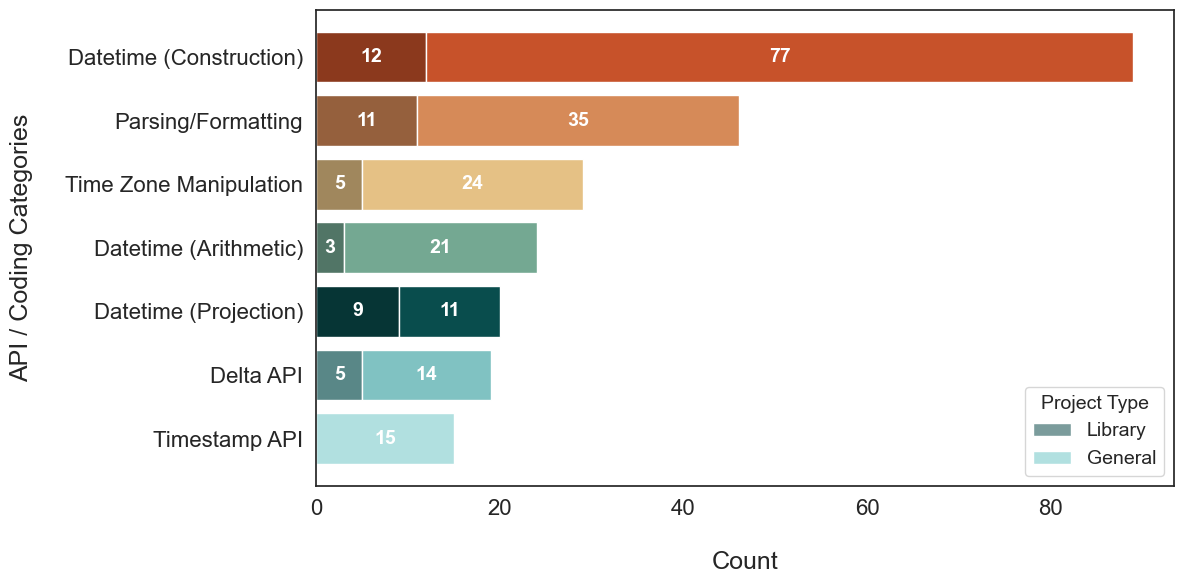

In [235]:
# Prepare the DataFrame
df_new = df[['Project', 'Erroneous Computation 1', 'Erroneous Computation 2', 'Erroneous Computation 3']]
df_new["In Library"] = df['Project'].apply(lambda x: "In Datetime Library" if x in datetime_libraries else "In General Project")

melted_df = df_new.melt(
    id_vars=["In Library"],
    value_vars=["Erroneous Computation 1", "Erroneous Computation 2", "Erroneous Computation 3"],
    value_name="Errors"
)

# Drop rows with NaN in the "Errors" column and select relevant columns
result_df = melted_df.dropna(subset=["Errors"])[["In Library", "Errors"]]

# Reset the index for the final DataFrame
result_df = result_df.reset_index(drop=True)

# Display the result
print(result_df)

# Group and count occurrences for each combination of "Errors" and "In Library"
grouped_data = result_df.groupby(["Errors", "In Library"]).size().unstack(fill_value=0)

# Sort bars by total counts (sum of both columns)
grouped_data["Total"] = grouped_data.sum(axis=1)
grouped_data = grouped_data.sort_values("Total", ascending=True).drop(columns=["Total"])

# Assign colors for each bar: original for "In Datetime Library" and lighter for "In General Project"
bar_colors = []
for i in range(len(grouped_data)):
    bar_colors.append((darker_colors[i], colors[i]))

# Plotting the horizontal stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))
for i, (library_type, color_pair) in enumerate(zip(grouped_data.columns, zip(*bar_colors))):
    ax.barh(
        grouped_data.index, grouped_data.iloc[:, i],
        label=library_type,
        color=color_pair,
        height=0.8,
        edgecolor="white",
        align="center",
        left=grouped_data.iloc[:, :i].sum(axis=1) if i > 0 else None,
    )

# Adding data labels
for container in ax.containers:
    labels = [f'{int(value)}' if value > 0 else '' for value in container.datavalues]
    ax.bar_label(container, labels=labels, label_type='center', color='white', fontsize=14, fontweight='bold')

# Customizing the chart
ax.set_xlabel("\nCount", fontsize=18)
ax.set_ylabel("API / Coding Categories\n", fontsize=18)
ax.legend(["Library", "General"], title="Project Type", fontsize=14, title_fontsize=14, loc="lower right")

# Adjusting ticks
ax.tick_params(axis="x", labelsize=16)
ax.tick_params(axis="y", labelsize=16)

# Adjust layout and display the chart
plt.tight_layout()
plt.savefig(SAVE_PATH + 'api_categories_stacked.pdf', bbox_inches='tight')
plt.show()

/var/folders/gg/nddyhpc10f5f1y17l64pb9_r0000gq/T/ipykernel_99932/1660288807.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new["In Library"] = df['Project'].apply(lambda x: "In Datetime Library" if x in datetime_libraries else "In General Project")


              In Library                      Bug Patterns
0     In General Project          Outdated/Deprecated APIs
1     In General Project    Dropping Time Zone Information
2    In Datetime Library            Unintuitive Arithmetic
3     In General Project          Outdated/Deprecated APIs
4     In General Project          Outdated/Deprecated APIs
..                   ...                               ...
177   In General Project              Comparing Time Zones
178   In General Project  Using Naïve Datetime Incorrectly
179  In Datetime Library              Comparing Time Zones
180  In Datetime Library       OOB Datetimes or Timestamps
181   In General Project      Incorrect Format Assumptions

[182 rows x 2 columns]


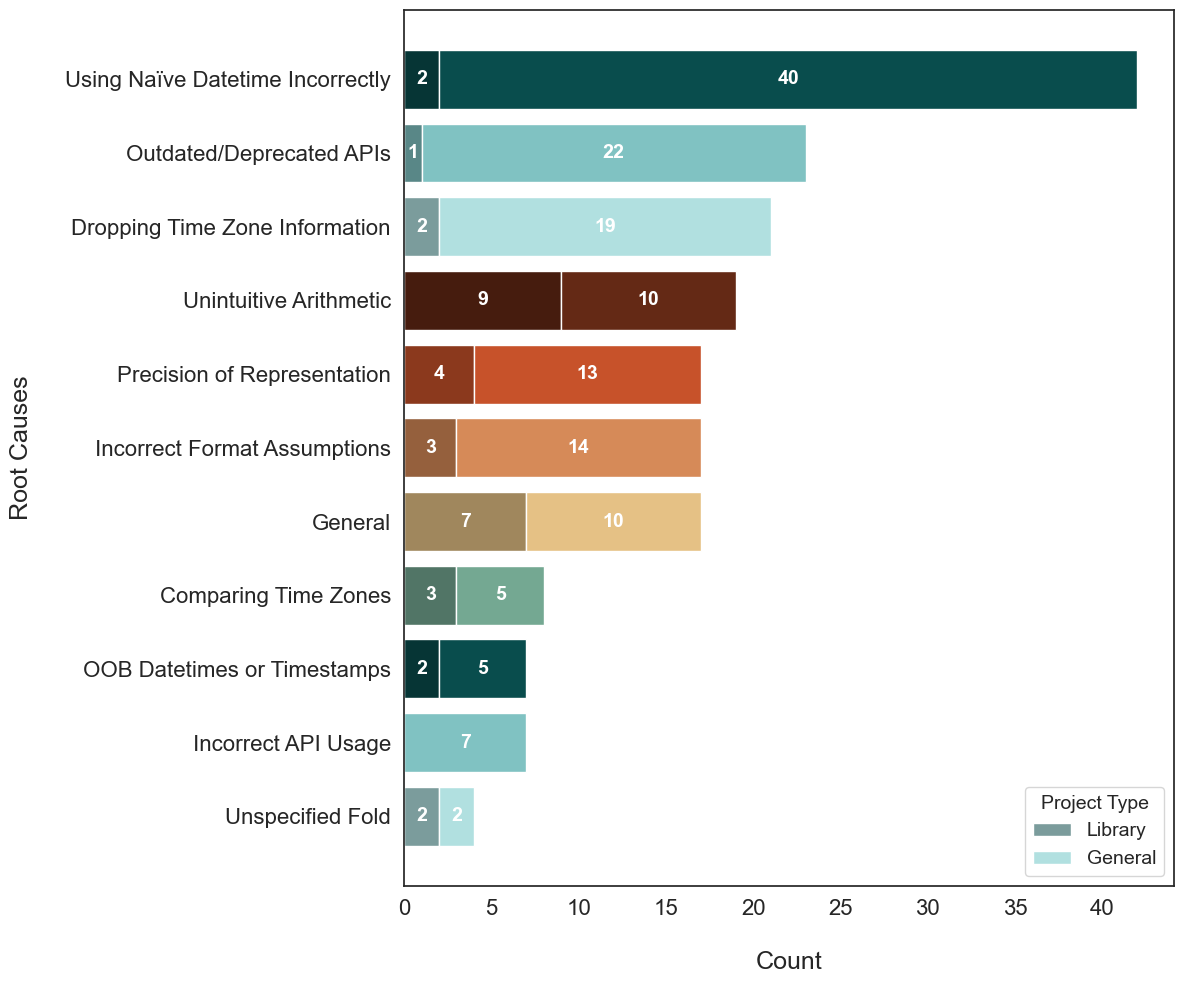

In [236]:
# Prepare the DataFrame (assuming you have a similar DataFrame setup to the reference code)
df_new = df[['Project', 'Bug Pattern 1', 'Bug Pattern 2', 'Bug Pattern 3']]
df_new["In Library"] = df['Project'].apply(lambda x: "In Datetime Library" if x in datetime_libraries else "In General Project")

melted_df = df_new.melt(
    id_vars=["In Library"],
    value_vars=['Bug Pattern 1', 'Bug Pattern 2', 'Bug Pattern 3'],
    value_name="Bug Patterns"
)

# Drop rows with NaN in the "Bug Patterns" column and select relevant columns
result_df = melted_df.dropna(subset=["Bug Patterns"])[["In Library", "Bug Patterns"]]

# Reset the index for the final DataFrame
result_df = result_df.reset_index(drop=True)

# Display the result
print(result_df)

# Group and count occurrences for each combination of "Bug Patterns" and "In Library"
grouped_data = result_df.groupby(["Bug Patterns", "In Library"]).size().unstack(fill_value=0)

# Sort bars by total counts (sum of both columns)
grouped_data["Total"] = grouped_data.sum(axis=1)
grouped_data = grouped_data.sort_values("Total", ascending=True).drop(columns=["Total"])

# Assign colors for each bar: original for "In Datetime Library" and lighter for "In General Project"
bar_colors = []
for i in range(len(grouped_data)):
    bar_colors.append((darker_colors[i%len(darker_colors)], colors[i%len(colors)]))

# Plotting the horizontal stacked bar chart
fig, ax = plt.subplots(figsize=(12, 10))
for i, (library_type, color_pair) in enumerate(zip(grouped_data.columns, zip(*bar_colors))):
    ax.barh(
        grouped_data.index, grouped_data.iloc[:, i],
        label=library_type,
        color=color_pair,
        height=0.8,
        edgecolor="white",
        align="center",
        left=grouped_data.iloc[:, :i].sum(axis=1) if i > 0 else None,
    )

# Adding data labels
for container in ax.containers:
    labels = [f'{int(value)}' if value > 0 else '' for value in container.datavalues]
    ax.bar_label(container, labels=labels, label_type='center', color='white', fontsize=14, fontweight='bold')

# Customizing the chart
ax.set_xlabel("\nCount", fontsize=18)
ax.set_ylabel("Root Causes\n", fontsize=18)
ax.legend(["Library", "General"], title="Project Type", fontsize=14, title_fontsize=14, loc="lower right")

# Adjusting ticks
ax.tick_params(axis="x", labelsize=16)
ax.tick_params(axis="y", labelsize=16)

# Adjust layout and display the chart
plt.tight_layout()
plt.savefig(SAVE_PATH + 'root_causes_stacked.pdf', bbox_inches='tight')
plt.show()

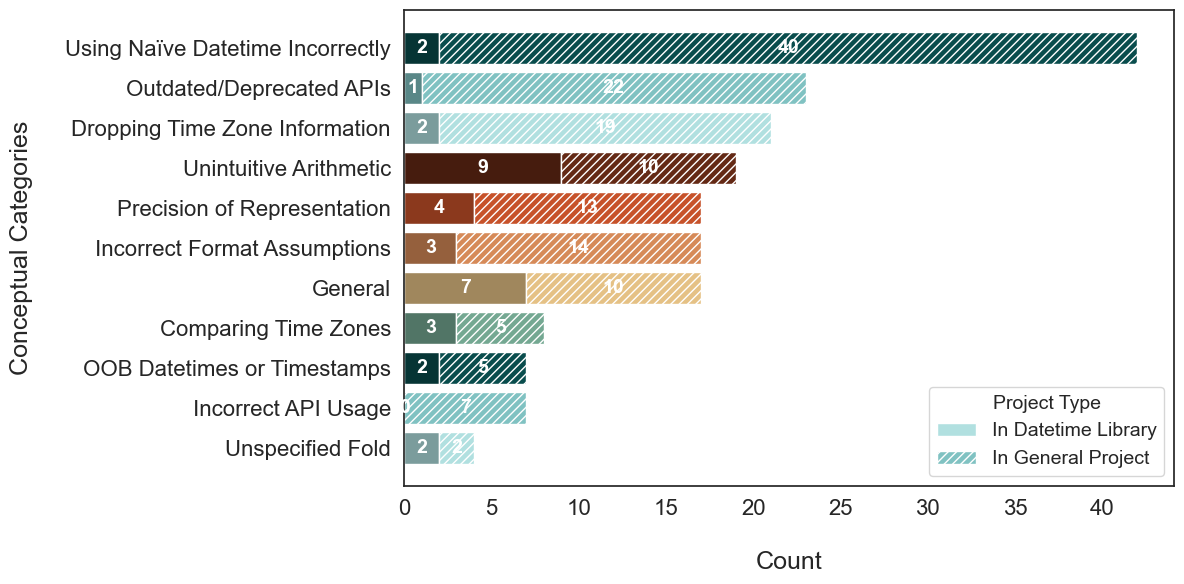

In [237]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

hatch_patterns=[ "", "////"]

# Plotting the stacked bar chart with hatching
fig, ax = plt.subplots(figsize=(12, 6))
for i, (library_type, color_pair) in enumerate(zip(grouped_data.columns, zip(*bar_colors))):
    ax.barh(
        grouped_data.index, grouped_data.iloc[:, i],
        label=library_type,
        color=color_pair,
        hatch=hatch_patterns[i],
        height=0.8,
        edgecolor="white",
        align="center",
        left=grouped_data.iloc[:, :i].sum(axis=1) if i > 0 else None,
    )

# Adding data labels
for container in ax.containers:
    ax.bar_label(container, label_type="center", color='white', fontsize=14, fontweight='bold')

# Customizing the chart
ax.set_xlabel("\nCount", fontsize=18)
ax.set_ylabel("Conceptual Categories\n", fontsize=18)

# Create custom legend handles with white edgecolor
legend_handles = [
    mpatches.Patch(facecolor=color, hatch=hatch, label=library_type, edgecolor='white')
    for color, hatch, library_type in zip(colors, hatch_patterns, grouped_data.columns)
]

# Add custom legend
ax.legend(handles=legend_handles, title="Project Type", fontsize=14, title_fontsize=14, loc="lower right")

# Adjusting ticks
ax.tick_params(axis="x", labelsize=16)
ax.tick_params(axis="y", labelsize=16)

# Display and save the chart
plt.tight_layout()
plt.show()